In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import confusion_matrix,recall_score, precision_score, f1_score
import warnings
warnings.filterwarnings("ignore")

<h3>Q1 & Q2 生成Data並輸出</h3>

In [2]:
# 定義一空的DataFrame
data = pd.DataFrame(columns=['ID','Gender','Age','Diagnosis'])

# 隨機性設定
np.random.seed(520)

# 生成流水號
data['ID'] = ['Test_' + str(i) for i in range(1, 501)]

# 生成性別各150筆
genders = np.concatenate([np.full(150, 'Female'), np.full(150, 'Male')])
# 補足到500筆資料後打亂
additional_genders = np.random.choice(['Female', 'Male'], size=200)
genders = np.concatenate([genders, additional_genders])
np.random.shuffle(genders)
data['Gender'] = genders

# 生成年齡資料
male_counts = len(data[data['Gender'] == 'Male'])
female_counts = len(data[data['Gender'] == 'Female'])
male_age = np.clip(np.random.normal(loc=59, scale=10, size=male_counts).astype(int),0,100)
female_age = np.clip(np.random.normal(loc=62, scale=12, size=female_counts).astype(int),0,100)
# 將Age資料放回data
data.loc[data['Gender'] == 'Male', 'Age'] = male_age
data.loc[data['Gender'] == 'Female', 'Age'] = female_age

# 生成發病狀況
data['Diagnosis'] = np.random.choice(['Positive', 'Negative'], size=500, p=[0.3, 0.7])

# 醫師診斷
data['Doctor_A'] = data['Diagnosis']
selected_indices = np.random.choice(data.index, size=int(500*0.225), replace=False)
data.loc[selected_indices, 'Doctor_A'] = data.loc[selected_indices, 'Diagnosis'].apply(lambda x: 'Negative' if x == 'Positive' else 'Positive')

data['Doctor_B'] = data['Diagnosis']
selected_indices = np.random.choice(data.index, size=int(500*0.175), replace=False)
data.loc[selected_indices, 'Doctor_B'] = data.loc[selected_indices, 'Diagnosis'].apply(lambda x: 'Negative' if x == 'Positive' else 'Positive')

data['Doctor_C'] = data['Diagnosis']
selected_indices = np.random.choice(data.index, size=int(500*0.125), replace=False)
data.loc[selected_indices, 'Doctor_C'] = data.loc[selected_indices, 'Diagnosis'].apply(lambda x: 'Negative' if x == 'Positive' else 'Positive')

data['FT_Output'] = data['Diagnosis']
selected_indices = np.random.choice(data.index, size=int(500*0.09), replace=False)
data.loc[selected_indices, 'FT_Output'] = data.loc[selected_indices, 'Diagnosis'].apply(lambda x: 'Negative' if x == 'Positive' else 'Positive')

In [3]:
# Output Data
# data.to_csv('/Users/changrobert/Desktop/Python/quiz/data.csv')

<h3>Q3 繪製Gender & Age 圖表</h3>

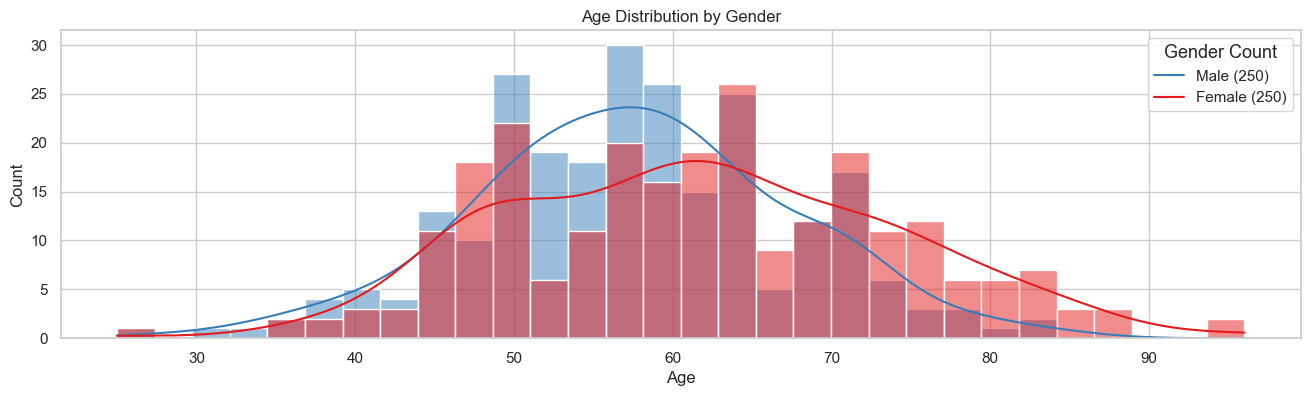

In [4]:
# 設定圖表風格大小
sns.set(style="whitegrid")
plt.figure(figsize=(16, 4))

# 繪製不同性別的年齡直方圖
ax = sns.histplot(data, x="Age", hue="Gender", bins=30, kde=True, palette="Set1")

# 加上標題和標籤
plt.title("Age Distribution by Gender")
plt.xlabel("Age")
plt.ylabel("Count")

legend_labels = [f'Male ({male_counts})', f'Female ({female_counts})']
ax.legend(legend_labels, title='Gender Count', title_fontsize='13')
# 顯示圖表
plt.show()

<h3>Q4 醫師診斷之一致性檢驗</>

In [5]:
# Fleiss-Kappa 前轉換
def transform(*raters):

    assert all(len(rater) == len(raters[0]) for rater in raters), "Lengths of raters are not consistent."
    
    subjects = len(raters[0])
    categories = max(max(rater) for rater in raters) + 1
    data = np.zeros((subjects, categories))
 
    for i in range(subjects):
        for rater in raters:
            data[i, rater[i]] += 1
    
    return data

In [6]:
# 将诊断结果改为0,1並轉換
table = (data[['Doctor_A','Doctor_B','Doctor_C']] == 'Positive').astype(int)
table_t = transform(table['Doctor_A'],table['Doctor_B'],table['Doctor_C'])

In [7]:
kappa_result = fleiss_kappa(table_t)
print("K value : " ,kappa_result)

K value :  0.3626175173952304


<h3>Q5 高達90%檢定</>

In [8]:
stat, p_value = proportions_ztest(500*0.91, 500, value=0.9, alternative='larger')
print(f"Z 值：{stat}\np 值：{p_value}")

Z 值：0.7813453848974932
p 值：0.2172996918469685


<h3>Q6 診斷能力與醫師相比</>

<h3>我 vs Doctor_A</>

In [9]:
# 計算 p-value
z_stat, p_value = proportions_ztest([500*0.91, round(500*0.775)], [500, 500],alternative='larger')
# 顯示檢定結果
print("檢定結果：")
print("z_stat:", z_stat)
print("p_value:", p_value)


檢定結果：
z_stat: 5.823863523803473
p_value: 2.87512695300949e-09


<h3>我 vs Doctor_B</>

In [10]:
z_stat, p_value = proportions_ztest([500*0.91, round(500*0.825)], [500, 500],alternative='larger')
# 顯示檢定結果
print("檢定結果：")
print("z_stat:", z_stat)
print("p_value:", p_value)

檢定結果：
z_stat: 4.004359740446481
p_value: 3.109283667641174e-05


<h3>我 vs Doctor_C</>

In [11]:
z_stat, p_value = proportions_ztest([500*0.91, round(500*0.875)], [500, 500],alternative='larger')
# 顯示檢定結果
print("檢定結果：")
print("z_stat:", z_stat)
print("p_value:", p_value)

檢定結果：
z_stat: 1.7391270220786466
p_value: 0.04100621124020692


<h3>Q7 研究補充</>

In [12]:
# 自己混淆矩陣計算Recall and F1
y_true = (data['Diagnosis'] == 'Positive').astype(int)
y_pred = (data['FT_Output'] == 'Positive').astype(int)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print("混淆矩阵:")
print(conf_matrix)
print("Recal : ",recall)
print("Precision :",precision)
print("F1-score :",f1)

混淆矩阵:
[[316  33]
 [ 12 139]]
Recal :  0.9205298013245033
Precision : 0.8081395348837209
F1-score : 0.8606811145510835


In [13]:
# Doctor_A混淆矩陣計算Recall and F1
y_true = (data['Diagnosis'] == 'Positive').astype(int)
y_pred = (data['Doctor_A'] == 'Positive').astype(int)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print("混淆矩阵:")
print(conf_matrix)
print("Recal : ",recall)
print("Precision :",precision)
print("F1-score :",f1)

混淆矩阵:
[[268  81]
 [ 31 120]]
Recal :  0.7947019867549668
Precision : 0.5970149253731343
F1-score : 0.6818181818181818


In [14]:
# Doctor_B混淆矩陣計算Recall and F1
y_true = (data['Diagnosis'] == 'Positive').astype(int)
y_pred = (data['Doctor_B'] == 'Positive').astype(int)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print("混淆矩阵:")
print(conf_matrix)
print("Recal : ",recall)
print("Precision :",precision)
print("F1-score :",f1)

混淆矩阵:
[[288  61]
 [ 26 125]]
Recal :  0.8278145695364238
Precision : 0.6720430107526881
F1-score : 0.741839762611276


In [15]:
# Doctor_C混淆矩陣計算Recall and F1
y_true = (data['Diagnosis'] == 'Positive').astype(int)
y_pred = (data['Doctor_C'] == 'Positive').astype(int)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print("混淆矩阵:")
print(conf_matrix)
print("Recal : ",recall)
print("Precision :",precision)
print("F1-score :",f1)

混淆矩阵:
[[306  43]
 [ 19 132]]
Recal :  0.8741721854304636
Precision : 0.7542857142857143
F1-score : 0.8098159509202453
